In [15]:
#import os
#jdbcPathUbuntu = '/usr/share/java/postgresql-42.2.23.jar'
#jdbcPathMacOS = '/Users/cristianomartinsm/postgresql-42.2.23.jar'
#jdbcPath = jdbcPathUbuntu
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-class-path ' + jdbcPath + ' --jars ' + jdbcPath + ' pyspark-shell'
#import databricks.koalas as ks
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
import matplotlib.lines as mlines
import psycopg2 as pg
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime, timedelta
import copy

In [16]:
kmLimit = 4000
subFolder = 'Free Floating/'
folderData = 'Optimal Solutions/' + subFolder + str(kmLimit) + '/'

textParams =    {'Free Floating/':  {'number': 0.7,
                                     'text': '07'},
                 'Mixed Free Floating/': {'number': 0.9,
                                             'text': '09'},
                 'Restricted 1 31 Partial Floating/':   {'number': 0.9,
                                                         'text': '09'},
                 'Restricted 1 62 Partial Floating/':   {'number': 0.9,
                                                         'text': '09'},
                 'Restricted 1 inf Partial Floating/':  {'number': 0.9,
                                                         'text': '09'}
                }

numberMultiplier = textParams[subFolder]['number']
textMultiplier = textParams[subFolder]['text']

dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                dataList.append((multiplierRounded, distanceCutOff, 4*float(optimalSolution["SolutionInfo"]["ObjVal"])))
        except FileNotFoundError:
            break

#dataFramePd = dataFrame.to_pandas()
dataFramePd = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'profit'])
dataFramePd = dataFramePd.pivot(index='multiplier', columns='distance', values='profit')
#dataFrame['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


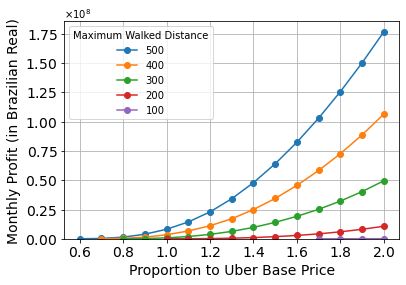

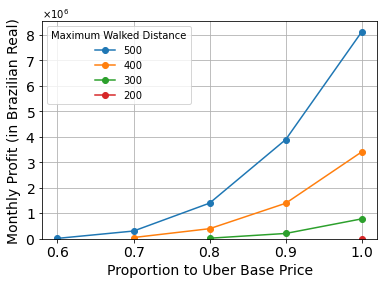

In [17]:
def formatFloat(value):
    numDecimaPlaces = 4
    return " & " + "{:.{nDigits}f}".format(value, nDigits=numDecimaPlaces)

def prepareLinePlot(dataFrame, xLabel, yLabel, legendTitle, fileName, xTicks=None, yTicks=None, yLim=[0, None], tickFormat=None):
    #Showing legend items backwards. Reindexing is better than sorting the legend_handles because it maintains the color order.
    dataFrame = dataFrame.reindex(columns=sorted(dataFrame.columns, reverse=True))

    ax = dataFrame.plot.line(fontsize=14, grid=True, marker='o')
    ax.legend(title=legendTitle)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(reversed(handles), reversed(labels)).set_title(legendTitle)

    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

folderSave = Path('./IEEE T-ITS/' + subFolder + str(kmLimit))
folderSave.mkdir(parents=True, exist_ok=True)

#PROFIT GRAPHS
fileName = folderSave / ('Profits_' + textMultiplier + '.eps')
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Monthly Profit (in Brazilian Real)",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
fileName = folderSave / ('Profits_' + textMultiplier + '_until_1.eps')
minPercentage = min(smallerDataFrame.index)
maxValueAmongAllColumns = max(smallerDataFrame.max())
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Monthly Profit (in Brazilian Real)",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5),
                        yTicks=np.arange(0, maxValueAmongAllColumns, pow(10, 6)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


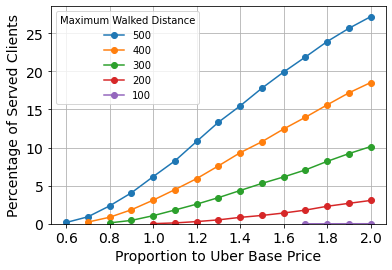

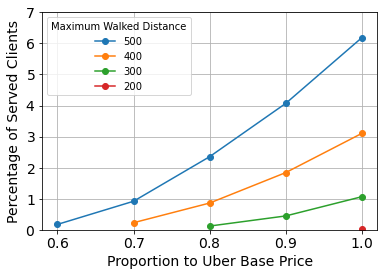

In [18]:
#SERVED CLIENTS GRAPH
def loadMaxAmountTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)
    cur = conn.cursor()

    sqlQuery = '''	select	sum(floor(TRIP.TRIPEXPANSIONFACTOR))
                    from	TRIP;
                    '''
    cur.execute(sqlQuery)
    maxAmountTrips = cur.fetchone()[0]
    cur.close()
    conn.close()

    return maxAmountTrips

def loadTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)

    sqlQuery = '''	select	TRIP.IDTRIP,
                            TRIP.TRIPEXPANSIONFACTOR,
                            TRIP.MAINMODE,
                            TRIP.DRIVINGDISTANCE,
                            TRIP.DRIVINGDURATION,
                            TRIP.TIMESTAMPDEPARTURE,
                            TRIP.TIMESTAMPARRIVAL,
                            TRIP.REASONDEPARTURE,
                            TRIP.REASONDESTINATION
                    from	TRIP
                    where   TRIP.DRIVINGDISTANCE > 500
                    '''
    dataFrameEdges = pd.read_sql_query(sqlQuery, conn)
    conn.close()

    trips = dict()
    for row in dataFrameEdges.itertuples():
        dictRow = row._asdict()
        trip = Trip(idTrip=dictRow['idtrip'],
                    expansionFactor=dictRow['tripexpansionfactor'],
                    mainMode=dictRow['mainmode'],
                    drivenDistance=dictRow['drivingdistance'],
                    drivenDuration=dictRow['drivingduration'],
                    timestampDeparture=dictRow['timestampdeparture'],
                    timestampArrival=dictRow['timestamparrival'],
                    departureReason=dictRow['reasondeparture'],
                    destinationReason=dictRow['reasondestination'])
        trips[trip.idTrip] = trip

    return trips

class Trip:
    #Values for defining the new timestamps
    ADJUSTED_MONTH = 1
    ADJUSTED_YEAR = 2017

    amountPeopleMainMode = {}
    amountServedMainMode = {numberMultiplier: {},
                            2: {}
    }
    
    amountPeopleDepartureReason = {}
    amountServedDepartureReason = { numberMultiplier: {},
                                    2: {}
    }
    amountPeopleDestinationReason = {}
    amountServedDestinationReason = {   numberMultiplier: {},
                                        2: {}
    }

    drivenDistances = { 'all':  [],
                        numberMultiplier:    [],
                        2:      []
    }

    def adjustDay(timeDepartureOld, drivingDuration):
        #The weekday() starts from 0 but it does not exist a day 0 in the calendar. Then, a +1 solves this issue
        adjustedDayDeparture = timeDepartureOld.weekday() + 1

        timeDepartureNew = timeDepartureOld.replace(day=adjustedDayDeparture, month=Trip.ADJUSTED_MONTH, year=Trip.ADJUSTED_YEAR)
        timeArrivalNew = timeDepartureNew + timedelta(minutes=drivingDuration)
        
        return timeDepartureNew, timeArrivalNew
    
    def incrementPeople(key, increment, dictToCheck, dictServed):
        if key not in dictToCheck:
            dictToCheck[key] = increment
            dictServed[numberMultiplier][key] = 0
            dictServed[2][key] = 0
        else:
            dictToCheck[key] += increment
        
    def __init__(self, idTrip, expansionFactor, mainMode, drivenDistance, drivenDuration, timestampDeparture, timestampArrival, departureReason, destinationReason):
        self.idTrip = idTrip
        self.expansionFactor = expansionFactor
        self.mainMode = mainMode
        self.drivenDistance = drivenDistance
        self.drivenDuration = drivenDuration
        self.timestampDepartureOld = timestampDeparture
        self.timestampArrivalOld = timestampArrival
        self.departureReason = departureReason
        self.destinationReason = destinationReason

        self.timestampDeparture, self.timestampArrival = Trip.adjustDay(timestampDeparture, self.drivenDuration)

        Trip.incrementPeople(self.mainMode, self.expansionFactor, Trip.amountPeopleMainMode, Trip.amountServedMainMode)
        Trip.incrementPeople(self.departureReason, self.expansionFactor, Trip.amountPeopleDepartureReason, Trip.amountServedDepartureReason)
        Trip.incrementPeople(self.destinationReason, self.expansionFactor, Trip.amountPeopleDestinationReason, Trip.amountServedDestinationReason)

        Trip.drivenDistances['all'].append(self.drivenDistance/1000)

maxAmountTrips = loadMaxAmountTrips()
allocatedStations = {}
amountServedTrips = {}
totalDrivenDistance = {}
stationsStart = {   numberMultiplier: dict(),
                    2: dict()
}
stationsBalance = { numberMultiplier: list(),
                    2: list()
}
INITIAL_TIMESTAMP = datetime(year=Trip.ADJUSTED_YEAR, month=Trip.ADJUSTED_MONTH, day=1, hour=0, minute=0, second=0)
trips = loadTrips()
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        percentagePrice = int(round(pricesMultiplier*100, 0))
        multiplierStable = round(pricesMultiplier, 1)

        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = 0
        amountServedTrips[keyTotalTrips] = 0
        totalDrivenDistance[keyTotalTrips] = 0
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    varVTagSplit = varVTag.split('_')

                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips] += amountVehicles

                            if distanceCutOff == 500 and multiplierStable in [numberMultiplier, 2]:
                                idStation = int(varVTagSplit[1])
                                stationsStart[multiplierStable][idStation] = amountVehicles
                                #stationsBalance[multiplierStable].append((idStation, INITIAL_TIMESTAMP, amountVehicles))

                    elif varVTag.startswith('trip'):
                        idTrip = int(varVTagSplit[1])
                        if varVTag.endswith('filter'):
                            amountServed = int(var["X"])
                            if amountServed > 0:
                                amountServedTrips[keyTotalTrips] += amountServed
                                totalDrivenDistance[keyTotalTrips] += amountServed * trips[idTrip].drivenDistance/1000
                            
                                if distanceCutOff == 500 and (multiplierStable == numberMultiplier or multiplierStable == 2):
                                    tripMainMode = trips[idTrip].mainMode
                                    tripDepartureReason = trips[idTrip].departureReason
                                    tripDestinationReason = trips[idTrip].departureReason
                                    Trip.amountServedMainMode[multiplierStable][tripMainMode] += amountServed
                                    Trip.amountServedDepartureReason[multiplierStable][tripDepartureReason] += amountServed
                                    Trip.amountServedDestinationReason[multiplierStable][tripDestinationReason] += amountServed

                                    Trip.drivenDistances[multiplierStable].append(trips[idTrip].drivenDistance/1000)

                        elif distanceCutOff == 500 and multiplierStable in [numberMultiplier, 2] and varVTagSplit[2] in ['start', 'end']:
                            idStation = int(varVTagSplit[4])
                            vehiclesFlow = int(var["X"])
                            if varVTagSplit[2] == 'start':
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampDeparture, -1*vehiclesFlow))
                            else:
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampArrival, vehiclesFlow))

                dataList.append((   pricesMultiplier,
                                    distanceCutOff,
                                    100*amountServedTrips[keyTotalTrips]/maxAmountTrips,
                                    allocatedStations[keyTotalTrips],
                                    4*totalDrivenDistance[keyTotalTrips]/allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'served', 'vehicles', 'drivendistance'])
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='served')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

fileName = folderSave / ('Served_' + textMultiplier + '.eps')
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Percentage of Served Clients",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='served')
lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / ('Served_' + textMultiplier + '_until_1.eps')
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Percentage of Served Clients",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5),
                        yTicks=range(0, 8))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


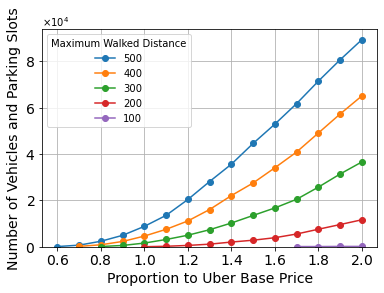

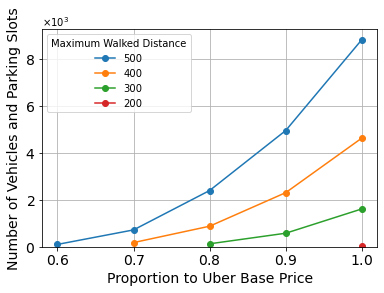

In [19]:
#NUMBER OF VEHICLES
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

fileName = folderSave / ('Vehicles_' + textMultiplier + '.eps')
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Number of Vehicles and Parking Slots",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
maxValueAmongAllColumns = max(smallerDataFrame.max())
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / ('Vehicles_' + textMultiplier + '_until_1.eps')
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Number of Vehicles and Parking Slots",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5))

distance          100          200          300          400          500
count        4.000000    11.000000    13.000000    14.000000    15.000000
mean      1980.211794  1549.941426  1951.146203  2222.629999  2427.019785
std         68.882287   263.729149   452.682168   563.739616   613.577440
min       1920.557984  1219.011948  1393.214099  1509.186651  1628.340027
25%       1920.557984  1325.398775  1583.243888  1763.801033  1902.384452
50%       1980.211794  1522.069169  1861.366542  2108.431278  2312.833604
75%       2039.865604  1768.639324  2266.671243  2655.669615  2999.836453
max       2039.865604  1936.967778  2785.899545  3135.723383  3330.045692


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


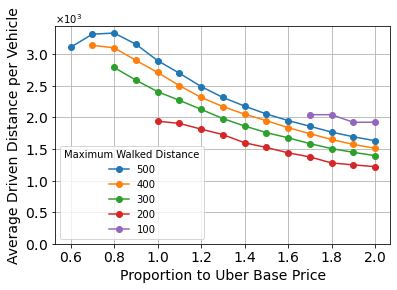

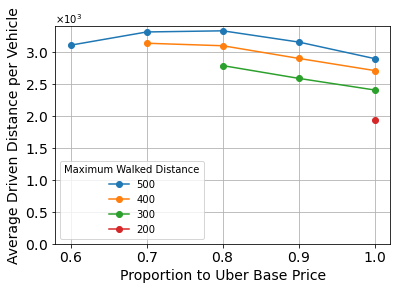

In [20]:
#AVERAGE DRIVEN DISTANCE PER VEHICLE
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='drivendistance')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
print(dataFramePd.describe())

maxValueAmongAllColumns = max(dataFramePd.max())
fileName = folderSave / ('DrivenDistance_' + textMultiplier + '.eps')
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Average Driven Distance per Vehicle",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())#,
                        #yTicks=np.arange(0, maxValueAmongAllColumns, 500))

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / ('DrivenDistance_' + textMultiplier + '_until_1.eps')
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Average Driven Distance per Vehicle",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5))#,
                        #yTicks=np.arange(0, maxValueAmongAllColumns, 500))

In [21]:
allocatedStations = {}
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = list()
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips].append(amountVehicles)

                dataList.append((multiplierRounded, distanceCutOff, allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

,0.7,2
count,25.000000,889.000000
mean,28.800000,100.523060
std,21.644861,100.069412
min,2.000000,1.000000
25%,9.000000,26.000000
50%,25.000000,67.000000
75%,39.000000,142.000000
max,73.000000,664.000000


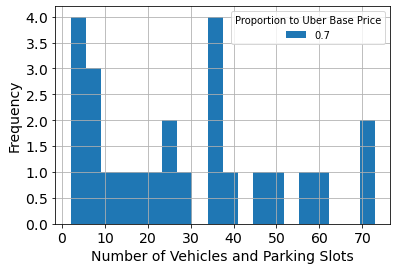

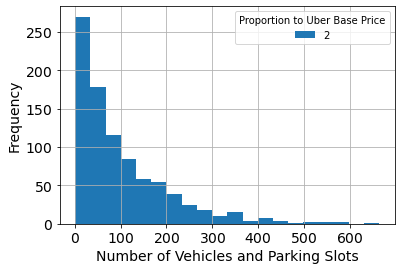

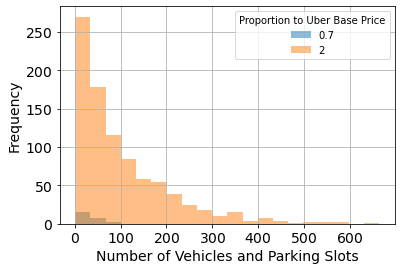

In [22]:
def prepareHistogram(dataFrame, xLabel, yLabel, legendTitle, fileName, amountBins=None, tickFormat=None, alpha=None):
    if amountBins is None:
        amountBins = 20
    if alpha is None:
        alpha = 1

    ax = dataFrame.plot.hist(bins=amountBins, alpha=alpha, grid=True)

    ax.legend(title=legendTitle)
    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'vehicles'])
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

dfHistogram1 = pd.DataFrame(dataFramePd[500][numberMultiplier],
                            columns = [numberMultiplier])
fileName = folderSave / ('Histogram_Vehicles_500_' + textMultiplier + '.eps')
ax = prepareHistogram(  dataFrame=dfHistogram1,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram2 = pd.DataFrame(dataFramePd[500][2],
                            columns = [2])
fileName = folderSave / ('Histogram_Vehicles_500_2.eps')
ax = prepareHistogram(  dataFrame=dfHistogram2,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram = pd.concat([dfHistogram1, dfHistogram2], axis=1, ignore_index=True)
dfHistogram.rename(columns={0: str(numberMultiplier), 1: '2'}, inplace=True)
fileName = folderSave / ('Histogram_Vehicles_500_' + textMultiplier + '_2.eps')
ax = prepareHistogram(  dataFrame=dfHistogram,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20,
                        alpha=0.5)
dfHistogram.describe()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

,all,0.7,2
count,40338.000000,2957.000000,22120.000000
mean,12.502112,6.996185,12.563055
std,16.007026,8.159138,15.602569
min,0.500068,0.504193,0.500068
25%,2.804227,1.916322,2.738525
50%,6.895904,4.500662,7.113950
75%,15.979090,8.921107,16.490508
max,263.890537,130.817405,263.890537


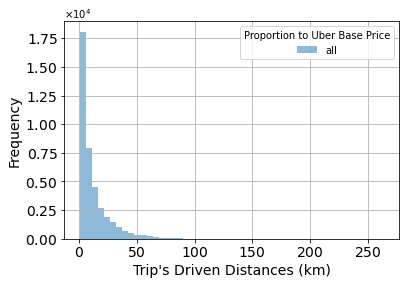

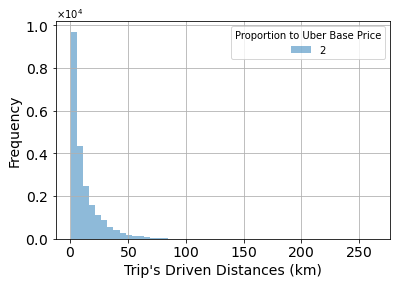

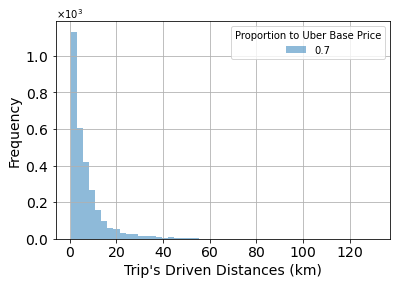

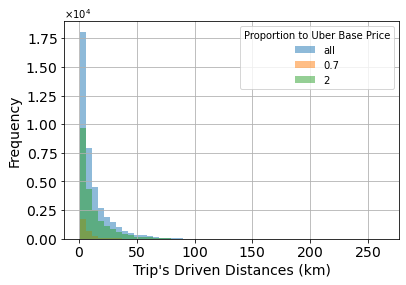

In [23]:
lengthAll = len(Trip.drivenDistances['all'])
length07 = len(Trip.drivenDistances[numberMultiplier])
length2 = len(Trip.drivenDistances[2])
Trip.drivenDistances[numberMultiplier].extend((lengthAll - length07) * [np.nan])
Trip.drivenDistances[2].extend((lengthAll - length2) * [np.nan])

dataFramePd = pd.DataFrame.from_dict(Trip.drivenDistances)
fileName = folderSave / 'Histogram_Distances_500_all.eps'
ax = prepareHistogram(  dataFrame=dataFramePd[['all']],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / 'Histogram_Distances_500_2.eps'
ax = prepareHistogram(  dataFrame=dataFramePd[[2]],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / ('Histogram_Distances_500_' + textMultiplier + '.eps')
ax = prepareHistogram(  dataFrame=dataFramePd[[numberMultiplier]],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / ('Histogram_Distances_500_' + textMultiplier + '_2_all.eps')
ax = prepareHistogram(  dataFrame=dataFramePd,
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

dataFramePd.describe()

####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000  6773.000000  6773.000000
mean   27659.735420     0.009459    12.460210
std    26218.269036     0.166394    17.978282
min        1.000000     0.000000     0.000000
25%     3757.000000     0.000000     0.000000
50%    11226.000000     0.000000     2.000000
75%    55363.000000     0.000000    21.000000
max    71547.000000     9.000000   154.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0           0.000000      111        0 2017-01-01 07:00:00
1           0.000000       22        0 2017-01-02 23:30:00
2           0.000000       19        0 2017-01-03 11:17:00
3           0.000000       19        0 2017-01-04 15:15:00
4           0.000000        1        0 2017-01-05 07:55:00
5           0.000000        1        0 2017-01-06 11:15:00
6           0.000000        1        0 2017-01-07 08:15:00
0           2.8888

/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000   6773.00000  6773.000000
mean   27659.735420     12.00812    12.460210
std    26218.269036     18.44737    17.978282
min        1.000000    -73.00000     0.000000
25%     3757.000000      0.00000     0.000000
50%    11226.000000      1.00000     2.000000
75%    55363.000000     21.00000    21.000000
max    71547.000000    154.00000   154.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0                -60     4981        0 2017-01-01 00:00:00.000000
1                -73     1276        0 2017-01-02 07:10:00.000000
2                -39      922        0 2017-01-03 12:01:07.299313
3                -39      922        0 2017-01-04 13:30:00.000000
4                -11    45130        0 2017-01-05 20:15:00.000000
5                -73     1276        0 2017-01-06 17:20:00.000000
6                -73 

/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 2 #######
            station   calcbalance       balance
count  59459.000000  59459.000000  59459.000000
mean   28047.045342      0.134121     46.306144
std    24479.612604      2.746181     82.977205
min        1.000000      0.000000      0.000000
25%     5127.000000      0.000000      0.000000
50%    17972.000000      0.000000     10.000000
75%    53327.000000      0.000000     57.000000
max    71580.000000    335.000000   1282.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0               0.00       13        0 2017-01-01 23:30:00
1               0.00       13        7 2017-01-02 17:30:00
2               0.00        1        0 2017-01-03 11:45:00
3               0.00       19        0 2017-01-04 15:15:00
4               0.00        1        0 2017-01-05 07:55:00
5               0.00        1        0 2017-01-06 08:30:00
6               0.00        1        0 2017-01-07 07:50:00
0 

/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 2 #######
            station   calcbalance       balance
count  59459.000000  59459.000000  59459.000000
mean   28047.045342     38.905801     46.306144
std    24479.612604     87.823777     82.977205
min        1.000000   -664.000000      0.000000
25%     5127.000000      0.000000      0.000000
50%    17972.000000      4.000000     10.000000
75%    53327.000000     52.000000     57.000000
max    71580.000000   1282.000000   1282.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0               -369    48158        0 2017-01-01 07:15:00
1               -565    62993        0 2017-01-02 16:10:00
2               -435    62993      130 2017-01-03 17:15:00
3               -664    24211        0 2017-01-04 08:50:00
4               -480    50085        0 2017-01-05 06:50:00
5               -518    37676        0 2017-01-06 08:15:00
6               -664    24211        0 2017-01-07 19:55:00
0 

/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_5188/1577321302.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


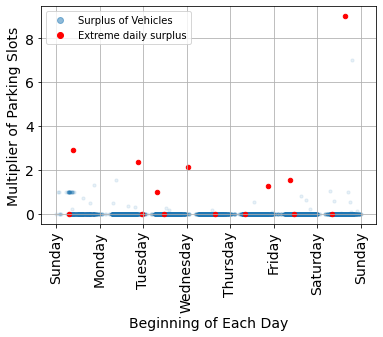

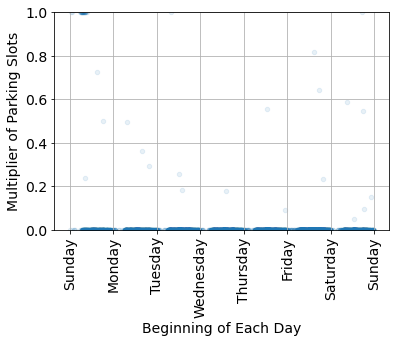

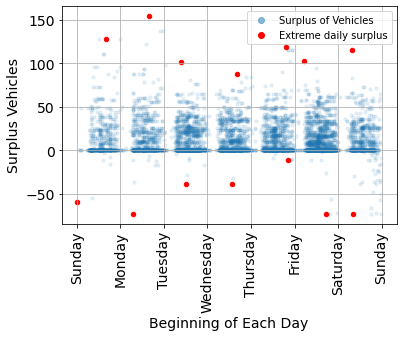

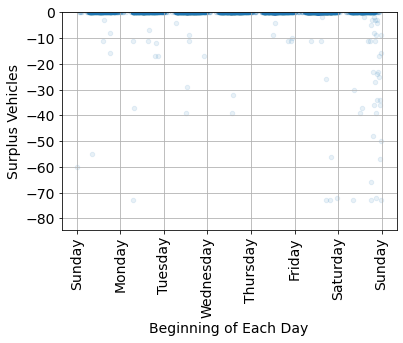

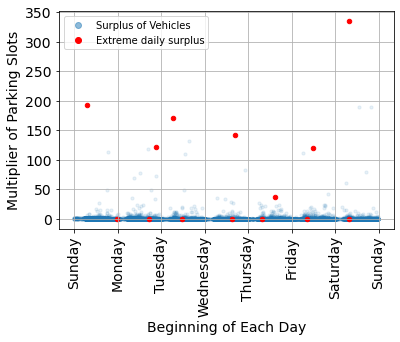

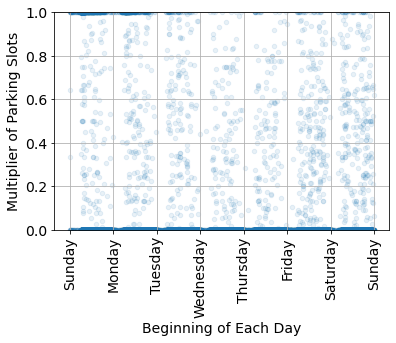

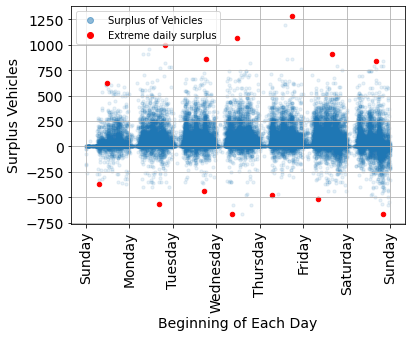

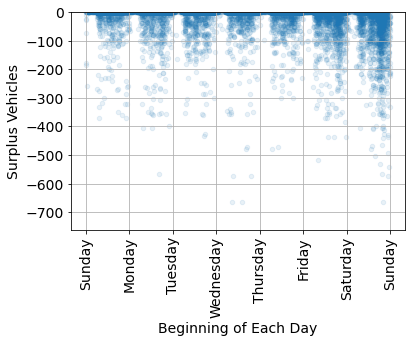

In [24]:
def prepareScatterPlot(dataFrame, xColumn, yColumn, xLabel, yLabel, fileName, legendTitle=None, legendLocation='best', pointSize=10, alpha=1, fontSize=14, color=None, rot=90, lastAx=None, lastAxColor=None, xTicks=None, yTicks=None, yLim=[None, None]):
    ax = dataFrame.plot.scatter(x=xColumn, y=yColumn, s=pointSize, alpha=alpha, fontsize=fontSize, c=color, rot=rot, grid=True, ax=lastAx)
   
    xTicksLoc, xTicksLabels = plt.xticks()
    newLabels = list()
    for xtick in xTicksLoc:
        newLabels.append(num2date(xtick).strftime("%A"))
    ax.set_xticklabels(newLabels)

    ax.set_xlabel(xLabel, fontsize=fontSize)
    ax.set_ylabel(yLabel, fontsize=fontSize)

    if lastAx is not None:
        bluePoint = mlines.Line2D([], [], color=lastAxColor, alpha=0.5, label='Surplus of Vehicles', marker='o', linestyle='None')
        redPoint = mlines.Line2D([], [], color='red', label='Extreme daily surplus', marker='o', linestyle='None')

        legendObject = ax.legend(handles=[bluePoint, redPoint], title=legendTitle, loc=legendLocation)

        legendObject = ax.legend(handles=[bluePoint, redPoint], title=legendTitle, loc=legendLocation)

    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)
    
    plt.savefig(fileName, format='pdf', bbox_inches="tight")
    #plt.show()

    return ax

def mergeExtremePoints(dataFrame, minOrMax):
    #Fixing pandas weekday to start at Sunday, as matplotlib and datetime uses
    dataFrame['weekday'] = dataFrame['timestamp'].dt.weekday
    dataFrame['weekday'] = np.where(dataFrame['weekday'] <= 5, dataFrame['weekday'] + 1, 0)

    if minOrMax == 'min':
        points = dataFrame.groupby(dataFrame['weekday'])[['calcbalance']].min()
    elif minOrMax == 'max':
        points = dataFrame.groupby(dataFrame['weekday'])[['calcbalance']].max()

    points.reset_index(inplace=True)
    points = pd.merge(points, dataFrame, on=['weekday', 'calcbalance'])
    points = points.groupby(points['weekday']).first()

    return points

def buildBalanceDataFrame(stationsBalance, pricesMultiplier):
    dataFramePd = pd.DataFrame(stationsBalance[pricesMultiplier], columns=['timestamp', 'station', 'calcbalance', 'balance'])
    dataFramePd = dataFramePd.set_index('timestamp')
    dataFramePd['timestamp'] = dataFramePd.index
    print('####### PRICE MULTIPLIER', pricesMultiplier, '#######')
    print(dataFramePd.describe())

    #Adjust the last points to the beginning of the first week
    mask = dataFramePd['timestamp'] >= INITIAL_TIMESTAMP + timedelta(weeks=1)
    dataFramePd.loc[mask, 'timestamp'] = dataFramePd.loc[mask, 'timestamp'].apply(lambda dateTooLate: dateTooLate - timedelta(weeks=1))

    minPoints = mergeExtremePoints(dataFrame=dataFramePd, minOrMax='min')
    maxPoints = mergeExtremePoints(dataFrame=dataFramePd, minOrMax='max')
    redPoints = pd.concat([minPoints, maxPoints])
    print(redPoints)

    return dataFramePd, redPoints

stationsAbsoluteBalance = copy.deepcopy(stationsBalance)
evaluatedMultipliers = [numberMultiplier, 2]
for pricesMultiplier in evaluatedMultipliers:    
    stationsBalance[pricesMultiplier].sort()
    stationsAbsoluteBalance[pricesMultiplier].sort()
    i = 0
    while i < len(stationsBalance[pricesMultiplier]):
        currentStation = stationsBalance[pricesMultiplier][i][0]
        if currentStation not in stationsStart[pricesMultiplier]:
            stationsStart[pricesMultiplier][currentStation] = 0

        earlierAbsoluteBalance = earlierBalance = stationsStart[pricesMultiplier][currentStation]

        while i < len(stationsBalance[pricesMultiplier]) and currentStation == stationsBalance[pricesMultiplier][i][0]:
            #Initially, idStation comes first in the tuple sequence to keep the sorting rationale
            (idStation, timestamp, vehiclesFlow) = stationsBalance[pricesMultiplier][i]
            if stationsStart[pricesMultiplier][currentStation] != 0:
                stationsBalance[pricesMultiplier][i] = (timestamp, idStation, earlierBalance/stationsStart[pricesMultiplier][currentStation], earlierBalance)
            else:
                stationsBalance[pricesMultiplier][i] = (timestamp, idStation, 0, earlierBalance)
            earlierBalance += vehiclesFlow

            (idStation, timestamp, vehiclesFlow) = stationsAbsoluteBalance[pricesMultiplier][i]
            stationsAbsoluteBalance[pricesMultiplier][i] = (timestamp, idStation, earlierAbsoluteBalance - stationsStart[pricesMultiplier][currentStation], earlierAbsoluteBalance)
            earlierAbsoluteBalance += vehiclesFlow

            i += 1

    #Repeating this line because there is no do_while loop in Python
    if stationsStart[pricesMultiplier][currentStation] != 0:
        stationsBalance[pricesMultiplier][i-1] = (timestamp, idStation, earlierBalance/stationsStart[pricesMultiplier][currentStation], earlierBalance)
    else:
        stationsBalance[pricesMultiplier][i-1] = (timestamp, idStation, 0, earlierBalance)
    stationsAbsoluteBalance[pricesMultiplier][i-1] = (timestamp, idStation, earlierAbsoluteBalance - stationsStart[pricesMultiplier][currentStation], earlierAbsoluteBalance)

    dataFramePd, redPoints = buildBalanceDataFrame(stationsBalance=stationsBalance, pricesMultiplier=pricesMultiplier)

    textMultiplierFileName = str(pricesMultiplier).replace('.', '')
    fileName = folderSave / ('Balance_' + textMultiplierFileName + '.pdf')
    xLabel='Beginning of Each Day'
    yLabel='Multiplier of Parking Slots'
    ax = prepareScatterPlot(dataFrame=dataFramePd,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            alpha=0.1,
                            fileName=fileName)
    ax = prepareScatterPlot(dataFrame=redPoints,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            pointSize=20,
                            color='red',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            fileName=fileName,
                            lastAx=ax)
    
    fileName = folderSave / ('Balance_' + textMultiplierFileName + '_until_10.pdf')
    ax = prepareScatterPlot(dataFrame=dataFramePd,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            pointSize=20,
                            alpha=0.1,
                            xLabel=xLabel,
                            yLabel=yLabel,
                            yLim=[0, 1],
                            fileName=fileName)

    dataFramePd, redPoints = buildBalanceDataFrame(stationsBalance=stationsAbsoluteBalance, pricesMultiplier=pricesMultiplier)

    fileName = folderSave / ('Absolute_Balance_' + textMultiplierFileName + '.pdf')
    yLabel='Surplus Vehicles'
    ax = prepareScatterPlot(dataFrame=dataFramePd,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            alpha=0.1,
                            fileName=fileName)
    ax = prepareScatterPlot(dataFrame=redPoints,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            pointSize=20,
                            color='red',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            fileName=fileName,
                            lastAx=ax)
    
    fileName = folderSave / ('Absolute_Balance_' + textMultiplierFileName + '_until_10.pdf')
    ax = prepareScatterPlot(dataFrame=dataFramePd,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            pointSize=20,
                            alpha=0.1,
                            xLabel=xLabel,
                            yLabel=yLabel,
                            yLim=[None, 0],
                            fileName=fileName)

In [25]:
def isStringFloat(text):
    try:
        float(text)
        return True
    except ValueError:
        return False

def prepareBarPlot(dictOfDataToPlot, dataForIndexing, translateKeys, sortedIndex,
                    xLabel, yLabel, fileName, xTicks=None, yTicks=None, yLim=[0, None], legendTitle=None, legendLocation='best', ax=None, zorder=None):
    dataFramePd = pd.DataFrame.from_dict(dictOfDataToPlot)
    dataFramePd.index = dataForIndexing
    dataFramePd = dataFramePd.rename(index=translateKeys)
    dataFramePd = dataFramePd.reindex(sortedIndex)

    ax = dataFramePd.plot.bar(fontsize=14, grid=True, ax=ax, zorder=zorder)
    handles, labels = ax.get_legend_handles_labels()
    i = 0
    while i < len(labels):
        if isStringFloat(labels[i]):
            labels[i] = str(int(100 * float(labels[i]))) + '% of Uber Base Price'
        i += 1
    legendObject = ax.legend(handles, labels, title=legendTitle, loc=legendLocation)

    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

def initDictMultiplierPercentages(evaluatedMultipliers):
    return {pricesMultiplier: list() for pricesMultiplier in evaluatedMultipliers}

def setDictionaries(dictPeople, dictServed, dictSharePeople, dictPercentageServed, dictSharedServed, evaluatedMultipliers):
    totalPeople = sum(dictPeople.values())
    for key, value in dictPeople.items():
        dictSharePeople[key] = 100*value/totalPeople

    for pricesMultiplier in evaluatedMultipliers:
        totalServedMultiplier = sum(dictServed[pricesMultiplier].values())
        for key, value in dictPeople.items():
            dictPercentageServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/value)
            dictSharedServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/totalServedMultiplier)

def getSortedKeys(dictSharePeople, translateKeys):
    #Renaming keys
    sortedKeysPeople = list()
    for key, value in translateKeys.items():
        if key in dictSharePeople:
            dictSharePeople[value] = [dictSharePeople.pop(key)]
            sortedKeysPeople.append(value)
    sortedKeysPeople = sorted(sortedKeysPeople, key=lambda x: dictSharePeople[x][0], reverse=True)

    return sortedKeysPeople

def getDataFrameSortedIndex(dictSharePeople, sortedKeysPeople):
    dataFramePd = pd.DataFrame.from_dict(dictSharePeople, orient='index', columns=['Actual share of demand'])
    dataFramePd = dataFramePd.reindex(sortedKeysPeople)

    return dataFramePd

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


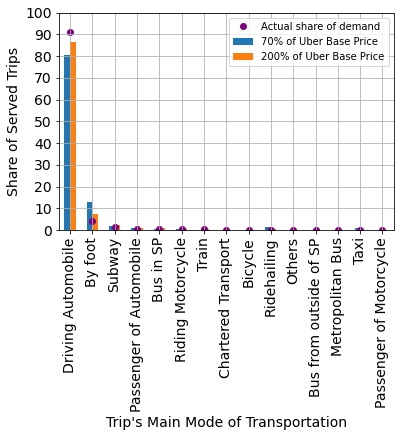

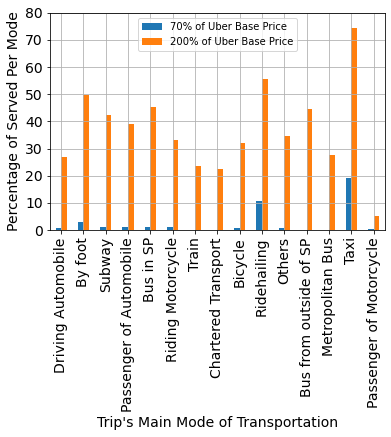

In [26]:
translateModes = {  1: 'Subway',
                    2: 'Train',
                    3: 'Monorail',
                    4: 'Bus in SP',
                    5: 'Bus from outside of SP',
                    6: 'Metropolitan Bus',
                    7: 'Chartered Transport',
                    8: 'Student\'s Transport',
                    9: 'Driving Automobile',
                    10: 'Passenger of Automobile',
                    11: 'Taxi',
                    12: 'Ridehailing',
                    13: 'Riding Motorcycle',
                    14: 'Passenger of Motorcycle',
                    15: 'Bicycle',
                    16: 'By foot',
                    17: 'Others'}

Trip.sharePeopleMainMode = dict()
Trip.percentageServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleMainMode,
                dictServed=Trip.amountServedMainMode,
                dictSharePeople=Trip.sharePeopleMainMode,
                dictPercentageServed=Trip.percentageServedMainMode,
                dictSharedServed=Trip.shareServedMainMode,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleMode = getSortedKeys(dictSharePeople=Trip.sharePeopleMainMode, translateKeys=translateModes)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleMainMode, sortedKeysPeople=sortedKeysPeopleMode)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Trips_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Share of Served Trips',
                    yLim=[0, 100],
                    yTicks=range(0, 110, 10),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Mode_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Percentage of Served Per Mode',
                    yLim=[0, 80],
                    yTicks=range(0, 90, 10),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


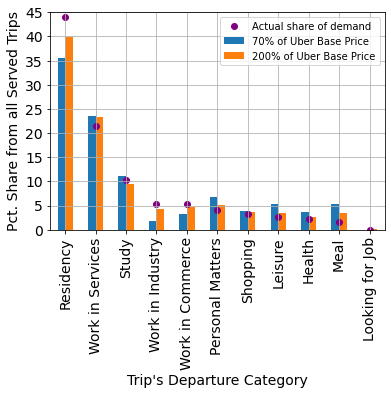

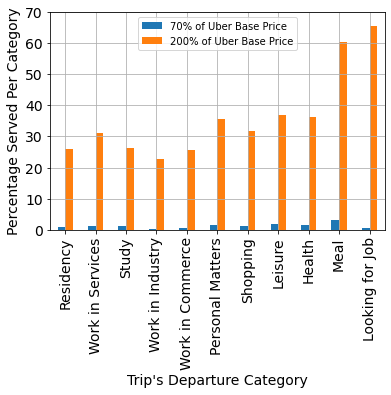

In [27]:
translateReasons = {1: 'Work in Industry',
                    2: 'Work in Commerce',
                    3: 'Work in Services',
                    4: 'Study',
                    5: 'Shopping',
                    6: 'Health',
                    7: 'Leisure',
                    8: 'Residency',
                    9: 'Looking for Job',
                    10: 'Personal Matters',
                    11: 'Meal'}

Trip.sharePeopleDepartureReason = dict()
Trip.percentageServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDepartureReason,
                dictServed=Trip.amountServedDepartureReason,
                dictSharePeople=Trip.sharePeopleDepartureReason,
                dictPercentageServed=Trip.percentageServedDepartureReason,
                dictSharedServed=Trip.shareServedDepartureReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDepartureReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDepartureReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Departure_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure Category',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 45],
                    yTicks=range(0, 50, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Departure_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure Category',
                    yLabel='Percentage Served Per Category',
                    yLim=[0, 70],
                    yTicks=range(0, 80, 10),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


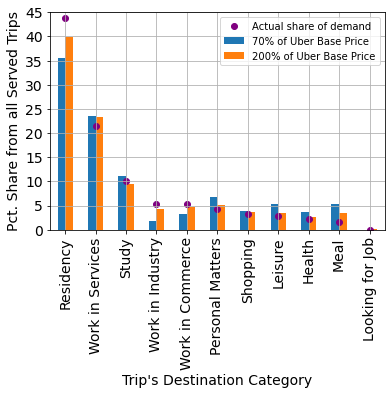

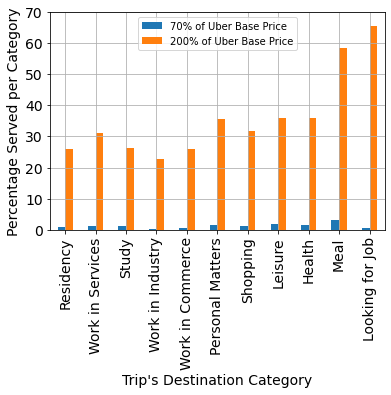

In [28]:
Trip.sharePeopleDestinationReason = dict()
Trip.percentageServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDestinationReason,
                dictServed=Trip.amountServedDestinationReason,
                dictSharePeople=Trip.sharePeopleDestinationReason,
                dictPercentageServed=Trip.percentageServedDestinationReason,
                dictSharedServed=Trip.shareServedDestinationReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDestinationReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDestinationReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Destination_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Destination Category',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 45],
                    yTicks=range(0, 50, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Destination_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Destination Category',
                    yLabel='Percentage Served per Category',
                    yLim=[0, 70],
                    yTicks=range(0, 80, 10),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)